In [1]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')
from dmdt_functions import *

In [2]:
import math
import numpy as np
import pandas as pd

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=10)

from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['axes.grid'] = False
# plt.style.use('seaborn-v0_8-colorblind')

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


**Let's load up our lightcurves**

In [3]:
qso_types = ['Q', 'QR', 'QX']

In [4]:
### Loading the features by name
features_by_name = pd.read_parquet(base_directory + 'original_features_by_name.parquet')
# features_by_name = features_by_name.dropna(axis=0)
# features_by_name = features_by_name.query("type in @qso_types")
### Sampling to save memory
# features_by_name = features_by_name.sample(frac=0.1)

### Loading the features by OID
features_by_oid = pd.read_parquet(base_directory + 'original_features_by_oid.parquet')
# features_by_oid = features_by_oid.dropna(axis=0)
# features_by_oid = features_by_oid.query("type in @qso_types")
### Sampling to save memory
# features_by_oid = features_by_oid.sample(frac=0.1)

In [5]:
def plot_numpy_histogram(ax, hist, bins, **kwargs):
    bincentres = (bins[1:] + bins[:-1]) / 2
    binwidths = np.diff(bins)
    hist = hist / hist.sum()
    ax.bar(bincentres, hist, width=binwidths, **kwargs)
    return ax

def plot_numpy_step(ax, hist, bins, **kwargs):
    hist = hist / hist.sum()
    ax.step(bins[:-1], hist, where='post', **kwargs)
    return ax

In [6]:
feature_names = ['T2020_sigma2', 'mhps_ratio', 'mhps_low', 'mhps_high', 'Amplitude', 'AndersonDarling', 'Autocor_length',
                 'Beyond1Std', 'Con', 'Eta_e', 'Gskew', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend',
                 'PercentAmplitude', 'Q31', 'PeriodLS_v2', 'Period_fit_v2', 'Psi_CS_v2', 'Psi_eta_v2', 'Rcs', 'Skew', 'SmallKurtosis',
                 'Std', 'StetsonK', 'Pvar', 'ExcessVar', 'GP_DRW_sigma', 'GP_DRW_tau', 'SF_ML_amplitude', 'SF_ML_gamma', 'IAR_phi',
                 'LinearTrend', 'Harmonics_mag_1', 'Harmonics_mag_2', 'Harmonics_mag_3', 'Harmonics_mag_4', 'Harmonics_mag_5',
                 'Harmonics_mag_6', 'Harmonics_mag_7', 'Harmonics_phase_2', 'Harmonics_phase_3', 'Harmonics_phase_4', 'Harmonics_phase_5',
                 'Harmonics_phase_6', 'Harmonics_phase_7', 'Harmonics_mse', 'mhps_non_zero', 'mhps_PN_flag']

In [7]:
feature_ranges = {
    'T2020_sigma2': (0, 0.2),
    'mhps_ratio': (0, 1000),
    'mhps_low': (0, 2),
    'mhps_high': (0, 0.2),
    'SmallKurtosis': (0, 20),
    'ExcessVar': (0, 0.0004),
    'GP_DRW_sigma': (0, 0.3),
    'GP_DRW_tau': (0, 4000),
    'SF_ML_amplitude': (0, 2),
    'LinearTrend': (-0.003, 0.003),
    'Harmonics_mag_1': (0, 400),
    'Harmonics_mag_2': (0, 400),
    'Harmonics_mag_3': (0, 400),
    'Harmonics_mag_4': (0, 400),
    'Harmonics_mag_5': (0, 400),
    'Harmonics_mag_6': (0, 400),
    'Harmonics_mag_7': (0, 400),
    'Harmonics_mse': (0, 0.1)
}

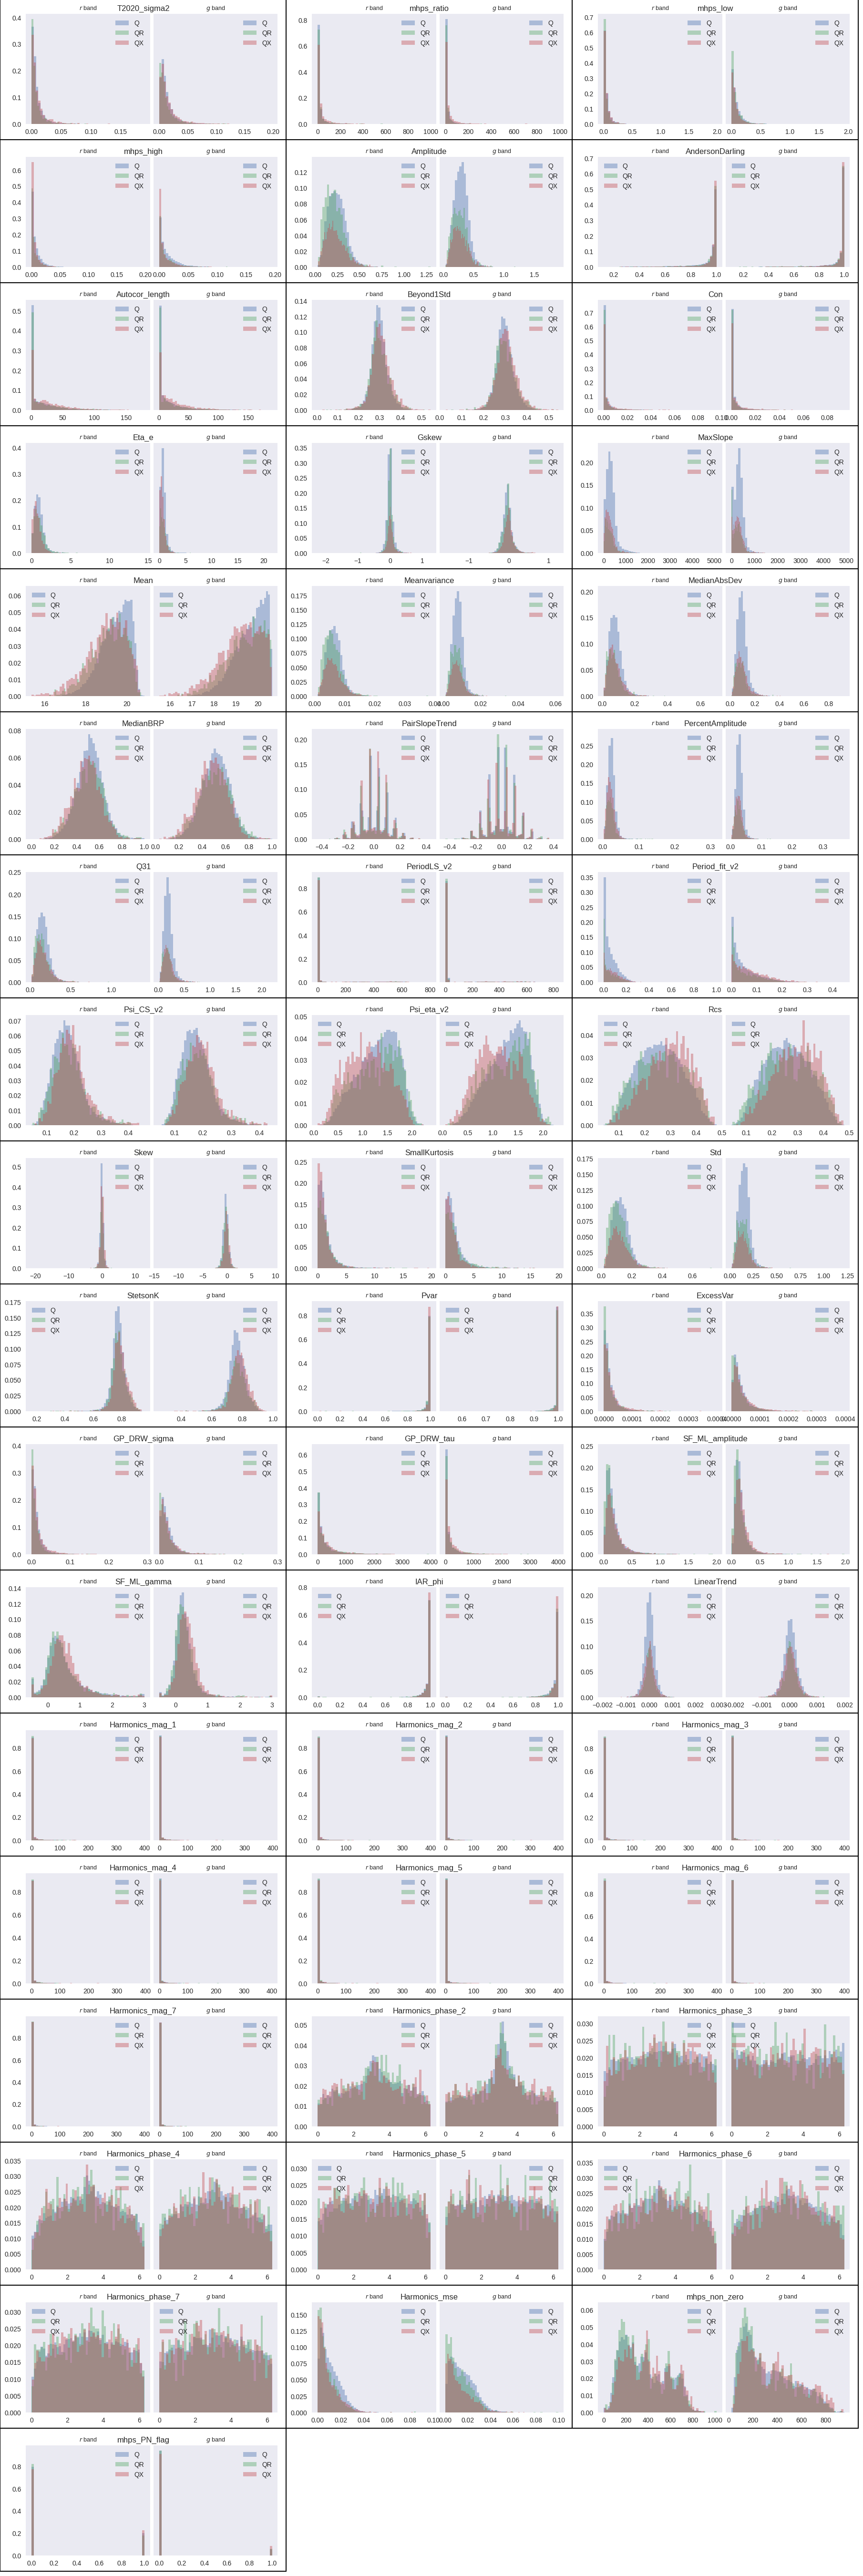

In [8]:
ncols_outer = 3
nrows_outer = math.ceil(len(feature_names) / ncols_outer)

ncols, nrows = 2, 1

bins = 50

fig = plt.figure(figsize=(6*ncols_outer, 3*nrows_outer))
subfigs = fig.subfigures(nrows_outer, ncols_outer)

for feature_name, subfig in zip(feature_names, subfigs.flatten()):
    subfig.patch.set_linewidth(0.1)
    subfig.patch.set_edgecolor('k')

    subfig.suptitle(feature_name, fontsize='12', y=0.94)
    subfig.subplots_adjust(right=0.97, left=0.09, wspace=0.03)

    axs = subfig.subplots(nrows=nrows, ncols=ncols, sharey=True)
    for ax, band in zip(axs, 'rg'):
        for class_name in qso_types:
            band_feature_name = f'{band}_{feature_name}'
            
            series = features_by_name.query("type == @class_name")[band_feature_name].replace([np.inf, -np.inf], np.nan).dropna()
            if feature_name in feature_ranges:
                range_min, range_max = feature_ranges[feature_name]
                series = series[(series >= range_min) & (series <= range_max)]

            hist, bin_edges = np.histogram(series, bins=bins)
            # plot_numpy_step(ax, hist, bin_edges, label=class_name)
            plot_numpy_histogram(ax, hist, bin_edges, label=class_name, alpha=0.4)
            ax.set_title(f'${band}$ band', size=9)
            ax.legend()
            
plt.show()